## This notebook help us run .py script on Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! nvidia-smi

Fri Jul  8 08:32:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
cd /content/drive/MyDrive/pyimagesearch/captcha_breaker

/content/drive/Othercomputers/My Laptop/pyimagesearch/captcha_breaker


In [ ]:
! python download_images.py --output downloads

In [ ]:
! python annotate.py --input downloads --annot dataset

[INFO] processing image 1/505
: cannot connect to X server 


In [5]:
! python train_model.py --dataset dataset --model output/lenet.hdf5

[INFO] compiling model...
2022-07-08 06:16:53.666105: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
[INFO] training network...
Epoch 1/15
48/48 [==============================] - 3s 14ms/step - loss: 2.1667 - accuracy: 0.2378 - val_loss: 2.1391 - val_accuracy: 0.2000
Epoch 2/15
48/48 [==============================] - 0s 6ms/step - loss: 2.0787 - accuracy: 0.3137 - val_loss: 2.0204 - val_accuracy: 0.6218
Epoch 3/15
48/48 [==============================] - 0s 5ms/step - loss: 1.9008 - accuracy: 0.5812 - val_loss: 1.7543 - val_accuracy: 0.3881
Epoch 4/15
48/48 [==============================] - 0s 5ms/step - loss: 1.4407 - accuracy: 0.7979 - val_loss: 1.1808 - val_accuracy: 0.5604
Epoch 5/15
48/48 [==============================] - 0s 5ms/step - loss: 0.6834 - accuracy: 0.9419 - val_loss: 0.3601 - val_accuracy: 1.0000
Epoch 6/15
48/48 [==========

##! python test_model.py --input downloads --model output/lenet.hdf5

[INFO] loading pre-trained network...


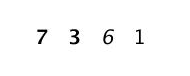

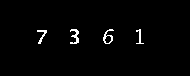

7[INFO] captcha: 3[INFO] captcha: 6[INFO] captcha: 1


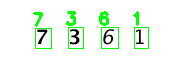

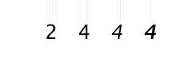

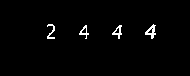

2[INFO] captcha: 4[INFO] captcha: 4[INFO] captcha: 4


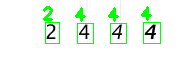

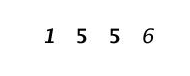

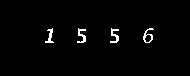

1[INFO] captcha: 5[INFO] captcha: 5[INFO] captcha: 6


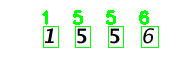

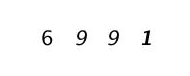

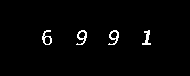

6[INFO] captcha: 9[INFO] captcha: 9[INFO] captcha: 1


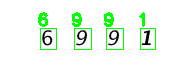

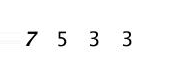

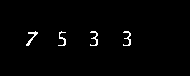

7[INFO] captcha: 5[INFO] captcha: 3[INFO] captcha: 3


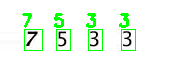

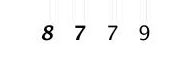

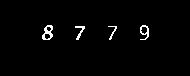

8[INFO] captcha: 7[INFO] captcha: 7[INFO] captcha: 9


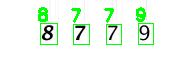

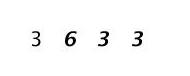

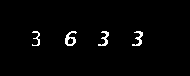

3[INFO] captcha: 6[INFO] captcha: 3[INFO] captcha: 3


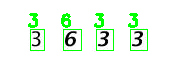

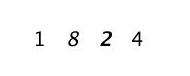

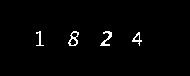

1[INFO] captcha: 8[INFO] captcha: 2[INFO] captcha: 4


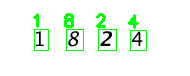

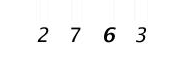

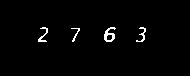

2[INFO] captcha: 7[INFO] captcha: 6[INFO] captcha: 3


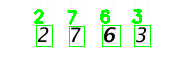

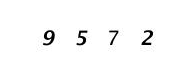

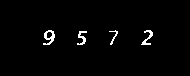

9[INFO] captcha: 5[INFO] captcha: 7[INFO] captcha: 2


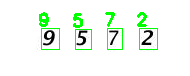

In [7]:
# import the necessary packages
import sys
sys.path.append("..")
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from utils.captchahelper import preprocess
from imutils import contours
from imutils import paths
import numpy as np
import argparse
import imutils
import cv2

# construct the argument parse and parse arguments

args = {
    'input': 'downloads',
    'model': 'output/lenet.hdf5'
}

# load the pre-trained network
print("[INFO] loading pre-trained network...")
model = load_model(args['model'])

# randomly sample a few of the input images
imagePaths = list(paths.list_images(args['input']))
imagePaths = np.random.choice(imagePaths, size = (10,),
                              replace=False)

# loop over the image paths
for imagePath in imagePaths:
    # load the image and convert it to grayscale, then pad the image
    # to ensure digits caught only the border of the image are
    # retained
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.copyMakeBorder(gray, 20, 20, 20, 20,
                              cv2.BORDER_REPLICATE)
    cv2_imshow(gray)
    # threshold the image to reveal the digits
    thresh = cv2.threshold(gray, 0, 255,
                           cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    cv2_imshow(thresh)

    # find contours in the image, keeping only the four largest ones,
    # then sort them from left-to-right
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                            cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:4]
    cnts = contours.sort_contours(cnts)[0]

    # initialize the output image as a 'grayscale' image with 3
    # channels along with the output predictions
    output = cv2.merge([gray] * 3)
    predictions = []

    # loop over the contours
    for c in cnts:
        # compute the bounding box for the contour then extract the
        # digit
        (x, y, w, h) = cv2.boundingRect(c)
        roi = gray[y - 5:y + h + 5, x - 5:x + w + 5]

        # pre-precess the ROI and classify it
        roi = preprocess(roi, 28, 28)
        roi = np.expand_dims(img_to_array(roi), axis=0) / 255.0
        pred = model.predict(roi).argmax(axis=1)[0] + 1
        predictions.append(str(pred))

        # draw the prediction on the output image
        cv2.rectangle(output, (x - 2, y - 2),
                     (x + w + 4, y + h + 4), (0, 255, 0), 1)
        cv2.putText(output, str(pred), (x - 5, y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0, 255, 0), 2)

    # show the output image
    print("[INFO] captcha: {}".format("").join(predictions))
    cv2_imshow(output)
    cv2.waitKey()

# python test_model.py --input downloads --model output/lenet.hdf5